## This notebook is simple to demonstrate the workflow on submitting a project in Kaggle. This is not meant to achive a great score, it was not performed any kind of model optimization or feature engineering. Some next steps if you want to keep exploring: 

* Do some proper feature engineer
* Extract some information from the Name column 
* Find a better way to fill the missing values
* Try to grid search for the hyperparameters
* Experiment different models

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

In [10]:
train = pd.read_csv('train.csv') # import the train dataset
test = pd.read_csv('test.csv') # import the test dataset

In [11]:
train.head() # check the first 5 lines of your dataframe

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [12]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

### Cool! We have our dataframes we can start working with it. Let's have an idea of what columns do we have. 

* remember: we are trying to predict the `Survived` column

In [13]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Let's look at each one of the variables and try to understand what's going on in there

#### Start with `Pclass`

In [14]:
train['Pclass'].value_counts() # here we can see a count of the values in this column 

3    491
1    216
2    184
Name: Pclass, dtype: int64

Text(0.5,1,'Pclass distribution')

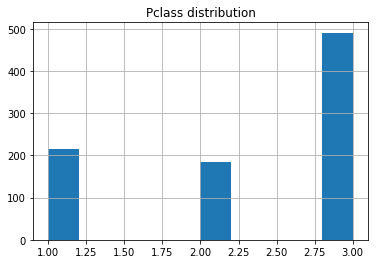

In [15]:
train['Pclass'].hist()
plt.title('Pclass distribution')

#### Sex

In [16]:
train['Sex'].value_counts() # more male than female

male      577
female    314
Name: Sex, dtype: int64

#### What about a combination of gender with other variableS? 

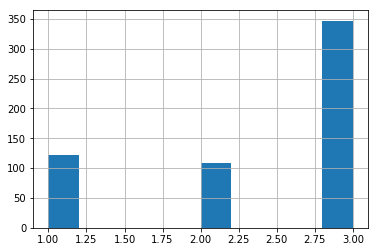

In [17]:
train[train['Sex'] == 'male'].Pclass.hist()

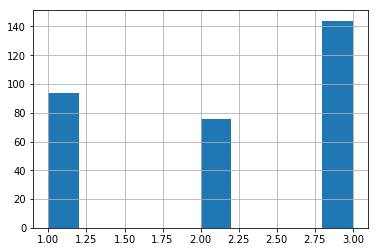

In [18]:
train[train['Sex'] == 'female'].Pclass.hist()

#### What about with surviving? 

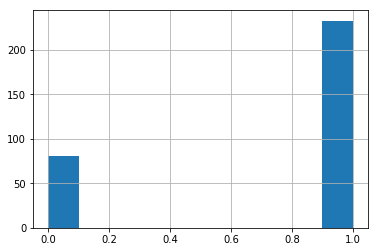

In [19]:
train[train['Sex'] == 'female'].Survived.hist()

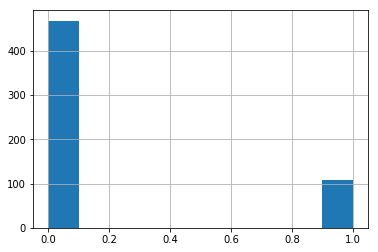

In [20]:
train[train['Sex'] == 'male'].Survived.hist()

### Hum... I'm seeing something here! Distributions seems to inverte for men and women. That makes sense right? 

* What about age?

In [21]:
train['Age'].isnull().sum()

177

> Crap! Lots of missing values! Let's fill those in

In [22]:
train['Age']=train['Age'].fillna(train.Age.mean()).apply(lambda x: int(x))

In [23]:
train.Age.isnull().sum() # no more nulls!

0

In [24]:
train[train['Age'] > 18].Survived.value_counts() # all the grown ups

0    480
1    272
Name: Survived, dtype: int64

In [25]:
train[train['Age'] < 18].Survived.value_counts() 

1    61
0    52
Name: Survived, dtype: int64

#### Seems like being young helps! 

In [26]:
train[train['Age'] < 10].Survived.value_counts()

1    38
0    24
Name: Survived, dtype: int64

### As this is a simple notebook just to serve as an example of what to do: let's just drop some columns and try to predict somethings in order to see the entire workflow

### I will drop `Name`, `SibSp`, `Ticket` and `Cabin`

* Pay attention to this! What you do on the **train set** you must do on the **test set**! 
* Because you should code under **DRY**, let's use a function for this

In [27]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [28]:
class CleanDataSet:
    """
    An object to make your pipeline very clear 
    """
    def __init__(self, df):
        self.df = df 
        
    # preprocessing happens here
    def preprocess(self): 
        self.df = self.df.drop(['Name', 'SibSp', 'Ticket', 'Cabin'], axis=1)
        self.df = pd.get_dummies(self.df, columns=['Pclass', 'Sex', 'Embarked'])
        self.df['Age'] = self.df['Age'].fillna(self.df.Age.mean()).apply(lambda x: int(x))
        self.df['Fare'] = self.df['Fare'].fillna(self.df.Fare.mean()).apply(lambda x: int(x))
        self.df = self.df.set_index('PassengerId')
        self.df.columns = [col.lower() for col in self.df.columns]
        return self.df    
    
    # we need to split the dataset
    def split_dataset(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.df.drop(['survived'], axis=1), 
            self.df.survived,
            test_size=0.2,
            random_state=42
            )
        return X_train, X_test, y_train, y_test

In [30]:
t = CleanDataSet(train)
t.preprocess()
X_train, X_test, y_train, y_test = t.split_dataset()
t.df.head() # our new dataset 

survived  age  parch  fare  pclass_1  pclass_2  pclass_3  \
PassengerId                                                             
1                   0   22      0     7         0         0         1   
2                   1   38      0    71         1         0         0   
3                   1   26      0     7         0         0         1   
4                   1   35      0    53         1         0         0   
5                   0   35      0     8         0         0         1   

             sex_female  sex_male  embarked_c  embarked_q  embarked_s  
PassengerId                                                            
1                     0         1           0           0           1  
2                     1         0           1           0           0  
3                     1         0           0           0           1  
4                     1         0           0           0           1  
5                     0         1           0           0           1

#### Now we can put a model doing this predictions. Let's use a Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Awesome! Our model learned something :D 

In [33]:
pred_proba = rf.predict_proba(X_test)[:, 1] # get the probabilities
pred = rf.predict(X_test) # get the values, already with cut-off. Default: 0.5

##### Our preds vector has a probability of being one! Notice how we selected the second column - remember, python starts counting at 0, which means when you choose 1 you are in fact choosing the second column``


### How can we evaluate before submitting if things are not overfitting

In [37]:
from sklearn.model_selection import cross_val_score

In [38]:
# How are we performing for cross-validation

scores = cross_val_score(rf, X_train, y_train, cv=5)
scores.mean() 

0.7978001121842897

### Now lets compare our predictions against the real ones that we hide from the model

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
accuracy_score(y_test, pred)

0.8324022346368715

### Ok our model is trained, we validaded.. seems legit! 

In [30]:
_test = CleanDataSet(test)
_test.preprocess()
_test.df.head()

age  parch  fare  pclass_1  pclass_2  pclass_3  sex_female  \
PassengerId                                                               
892           34      0     7         0         0         1           0   
893           47      0     7         0         0         1           1   
894           62      0     9         0         1         0           0   
895           27      0     8         0         0         1           0   
896           22      1    12         0         0         1           1   

             sex_male  embarked_c  embarked_q  embarked_s  
PassengerId                                                
892                 1           0           1           0  
893                 0           0           0           1  
894                 1           0           1           0  
895                 1           0           0           1  
896                 0           0           0           1

In [31]:
submit_preds = rf.predict(_test.df)

### Let's submit some kagle predictions to see how we are

In [32]:
# We need to take a look at Kagle's submission example

In [40]:
ex = pd.read_csv('gender_submission.csv')

In [34]:
_test.df['Survived'] = submit_preds # add our predictions vector to the dataframe

In [35]:
# put it in the form that Kagle asks for 
submit_df = _test.df.reset_index() 
submit_df = submit_df[['PassengerId', 'Survived']]

### Prepare for submission

In [36]:
submit_df.to_csv('simple_submission.csv', index=False)